# Summary statement

I believe we have validated the mini ASTE with the gateway term but this took a lot of finagling. Let's try to load the J terms from the 2007 run and show that these are the same as with our G term calculation as well as the J terms we did before for the ASTE 270 grid. 

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



## Load the gateways for the ASTE 270 grid

In [2]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

# the BSO reading is also wrong
choose_UV_bso[20] = "H"
x_bso[x_bso == 161] = 162

In [3]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

In [4]:
# we should redefine gates I think
# start with NaNs (float array so NaN is valid)
gates = np.full((ny, nx), np.nan, dtype=float)

def _paint(x_idx, y_idx, value):
    x = np.asarray(x_idx, dtype=int)
    y = np.asarray(y_idx, dtype=int)
    # keep only points inside the domain
    m = (y >= 0) & (y < ny) & (x >= 0) & (x < nx)
    gates[y[m], x[m]] = value

# 1,2,3,4 for BSO, SFJ, FJNZ, NZRU
_paint(x_bso,  y_bso,  1)
_paint(x_sfj,  y_sfj,  2)
_paint(x_fjnz, y_fjnz, 3)
_paint(x_nzru, y_nzru, 4)

(400.0, 540.0)

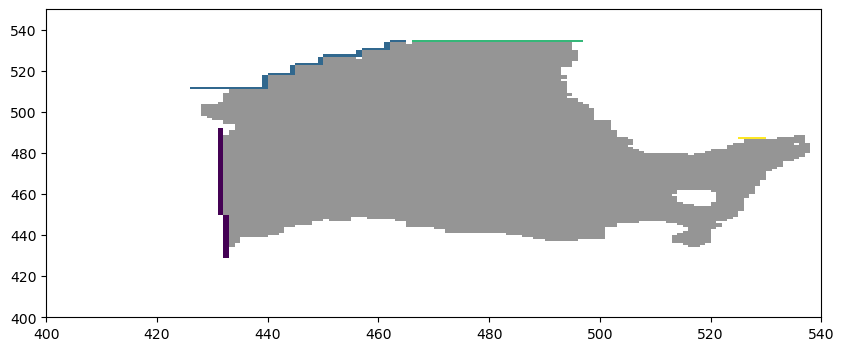

In [5]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0],cmap="Greys",vmin=-2,vmax=4)
plt.pcolormesh(get_aste_tracer(gates,nfx,nfy)[0])
plt.ylim(400,550)
plt.xlim(400,540)

In [6]:
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

In [7]:
# INDICES WE WANT TO READ FROM 
# make long sets of these so we can loop through later
ix_all = np.concatenate((x_bso,x_sfj,x_fjnz,x_nzru))
iy_all = np.concatenate((y_bso,y_sfj,y_fjnz,y_nzru))
choose_all = np.concatenate((choose_UV_bso,choose_UV_sfj,choose_UV_fjnz,choose_UV_nzru))

(1.0, 120.0)

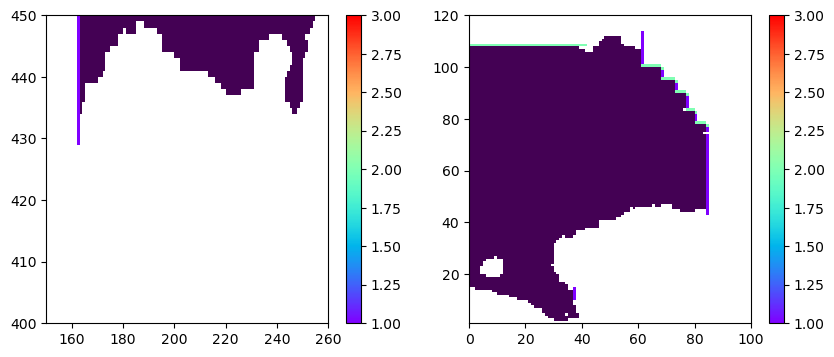

In [8]:
a = get_aste_faces(mymsk,nfx,nfy)
# b = get_aste_faces(gates,nfx,nfy)

# rather than plotting gates here I want to color these by the x,y indices so that we can double check again
# let's just add these as 1,2, or 3 for H V or B
gates_check = np.full((ny,nx),np.nan)
for j,i,c in zip(iy_all,ix_all,choose_all):
    if c == "H":
        gates_check[j,i] = 1
    elif c == "V":
        gates_check[j,i] = 2
    elif c == "B":
        gates_check[j,i] = 3

b = get_aste_faces(gates_check,nfx,nfy)


fig = plt.figure()

ax = plt.subplot(121)
ax.pcolormesh(a.f1[0])
cb = ax.pcolormesh(b.f1[0],cmap='rainbow',vmin=1,vmax=3)
plt.colorbar(cb)
ax.set_xlim(150, 260)
ax.set_ylim(400, 450)

ax = plt.subplot(122)
ax.pcolormesh(a.f3[0])
cb = ax.pcolormesh(b.f3[0], cmap='rainbow',vmin=1,vmax=3)
plt.colorbar(cb)
ax.set_xlim(0, 100)
ax.set_ylim(1, 120)

In [9]:
# we need to write out the indices we want to set at (ie the edge boxes where we have inflow)
x_set_bso = x_bso.copy() # this will be the same throughout for the bso
y_set_bso = y_bso.copy()
y_set_bso[21:] -= 1

# for sfj this will be longer than the original array but everything needs -= 1
x_set_sfj,y_set_sfj = np.array([]), np.array([])
for j,i,c in zip(y_sfj,x_sfj,choose_UV_sfj):
    if c == "H":
        # append j as is, append i-1
        y_set_sfj = np.append(y_set_sfj,j)
        x_set_sfj = np.append(x_set_sfj,i-1)
    elif c == "V":
        # append i as is, append j-1
        y_set_sfj = np.append(y_set_sfj,j-1)
        x_set_sfj = np.append(x_set_sfj,i)
    elif c == "B":
        # append twice -- once for i-1 and j, once for j-1 and i
        y_set_sfj = np.append(y_set_sfj,j-1)
        x_set_sfj = np.append(x_set_sfj,i)
        y_set_sfj = np.append(y_set_sfj,j)
        x_set_sfj = np.append(x_set_sfj,i-1)
        
# for fjnz and nzru these will all be -= 1 for i/x
x_set_fjnz = x_fjnz -1
y_set_fjnz = y_fjnz.copy()
x_set_nzru = x_nzru -1
y_set_nzru = y_nzru.copy()

# expand the sfj set to account for the change in indices

# If you already expanded x_set_sfj, y_set_sfj (including the two entries for each "B"),
# expand choose_UV_sfj to match:
def expand_choose_for_sfj(choose_src):
    out = []
    for c in choose_src:
        if c == "H":
            out.append("H")
        elif c == "V":
            out.append("V")
        elif c == "B":
            # MUST match how you appended indices for B:
            # you did: (j-1, i)  -> V   then  (j, i-1) -> H
            out.extend(["V", "H"])
    return np.array(out, dtype=object)

choose_set_sfj = expand_choose_for_sfj(choose_UV_sfj)

# (Optional) sanity check lengths align
assert len(choose_set_sfj) == len(x_set_sfj) == len(y_set_sfj), "SFJ choose/indices length mismatch"

In [10]:
# INDICES WE WANT TO WRITE TO
# make a similar arrangement of the set indices we want to set the values at in the C grid
ix_set_all = np.concatenate((x_set_bso,x_set_sfj,x_set_fjnz,x_set_nzru))
iy_set_all = np.concatenate((y_set_bso,y_set_sfj,y_set_fjnz,y_set_nzru))
choose_set_all = np.concatenate((choose_UV_bso,choose_set_sfj,choose_UV_fjnz,choose_UV_nzru))

## Load the items from the layers output (we can use 2007 here as an example)

In [11]:
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(3,4,1)
# times['2008'] = np.array([1])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

# dt = 

{'2007': array([3])}


array(['0000271440'], dtype='<U32')

In [12]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/BarentsS_paper/figs/"
dirdiags = layers_path + "diags/BUDG/"
dirLayers = layers_path + "diags/LAYERS/"
dirLayersCwet = layers_path + "diags/LAYERS_Cwet/"
dirState = layers_path + "diags/STATE/"
dirgridw = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [13]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_centers,binsSLT_centers)
# Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbincentp,Sbincentp = np.meshgrid(binmidTp,binmidSp)
nS,nT = 112,112

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

## Load the G terms from Layers

In [14]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + str(tsstr[-1])+ ".meta")
metaS=parsemeta(layers_path + "diags/LAYERS/layers_3d_Stend." + str(tsstr[-1])+ ".meta")
nFldsS = metaS["fldList"]
nFldsT = metaT["fldList"]
print(len(nFldsS))
print(len(nFldsT))
setTtend=nFldsT.copy()
setStend=nFldsS.copy()

24
24


In [15]:
# check for the correct diagnostics
metaS['fldList']
a = metaS['fldList']
# print(a[12],a[13],a[14],a[19],a[20],a[23])  # surf 
ifldS = np.array([12,13,14,19,20,23])  # total tend, surf, hDiff, vDiff, hADV, vADV

metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
# print(b[0],b[1],b[2],b[7],b[8],b[11])
ifldT = np.array([0,1,2,7,8,11])    # surf, hDiff, vDiff, hADV, vADV, total tend

print(np.array(a)[ifldS]) # for G_S
print()
print(np.array(b)[ifldT]) # for G_T

['LaSs1SLT' 'LaSh1SLT' 'LaSz1SLT' 'LSha1SLT' 'LSza1SLT' 'LSto1SLT']

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']


(400.0, 600.0)

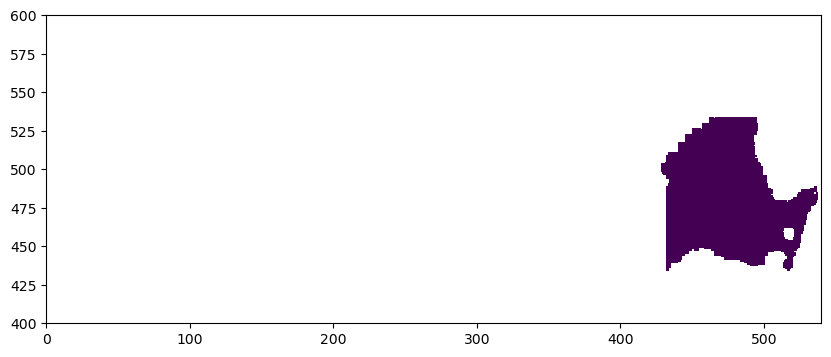

In [16]:
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])
plt.ylim(400,600)

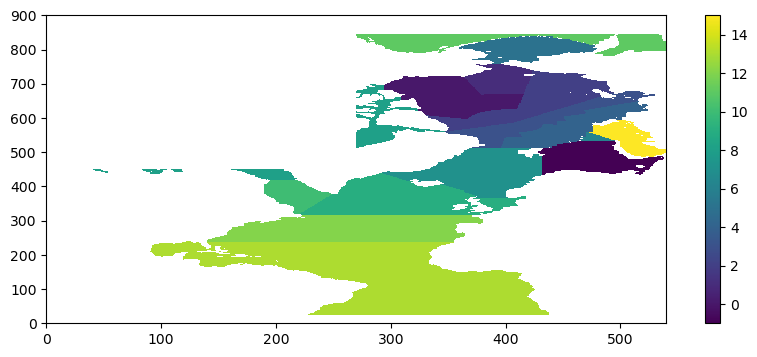

In [17]:
# do another mask with mymsk so we can look at this
mskBasin[mymsk == 1] = -1

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.flatten()
ind2d_wet = ind2d[iwetC2d]

orig_shape = ind2d.shape

mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
iwet_mine = np.where(~np.isnan(mymsk_1d[iwetC2d]))
iwet_mine[0].shape
iwet_mine = iwet_mine[0]

In [18]:
iwet_mine

array([48231, 48232, 48233, ..., 73277, 73278, 73279])

In [19]:
# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (146614,)
(4833023,)


In [20]:
# make the G_T term
G_T = {}
name = "BarentsS"
G_T[name] = {}
    
# now loop through
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float32_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp

    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_mine],axis=1)
    G_T[name][setTtend[ifldT[i]]] = a

G_T[name]["residT"] = np.nansum(residT[:,iwet_mine],axis=1)

In [21]:
# create G_S for all basins (line 258)
G_S = {}
G_S[name] = {}

# now loop through similar to ifldS
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float32_skip(layers_path + "diags/LAYERS/layers_3d_Stend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldS.shape[0]-1:
        # if LSto1SLT, do not remove from residual, this is the total tendency
        residS = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residS = residS-tmp

    # just do for the Barents Sea
    a = np.nansum(tmp[:,iwet_mine],axis=1)
    G_S[name][setStend[ifldS[i]]] = a

# loop through again to calculate resid
G_S[name]["residS"] = np.nansum(residS[:,iwet_mine],axis=1)

## Load and validate the G terms offline

In [22]:
# we need to recreate the TS string from these timesteps

In [23]:
times = {}
times['2007'] = np.arange(2,4,1)
# times['2008'] = np.array([1])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

{'2007': array([2, 3])}


2419200.0

In [24]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

ETAN = np.full((len(tsstr),ny,nx),np.nan)
PHIBOT = np.full((len(tsstr),ny,nx),np.nan)
SIheff = np.full((len(tsstr),ny,nx),np.nan)
SIhsnow = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    thisETAN,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisETAN = thisETAN.reshape(ny,nx)
    ETAN[i] = thisETAN

    thisPHIBOT,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisPHIBOT = thisPHIBOT.reshape(ny,nx)
    PHIBOT[i] = thisPHIBOT

    thisSIheff,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[2])
    thisSIheff = thisSIheff.reshape(ny,nx)
    SIheff[i] = thisSIheff

    thisSIhsnow,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[3])
    thisSIhsnow = thisSIhsnow.reshape(ny,nx)
    SIhsnow[i] = thisSIhsnow

dETANdt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt

In [25]:
# 3D, with rStar:
# mk3D_mod function should be called here but I might be doing it wrong
tmptend = np.zeros((nz, ny, nx))
if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
    tmptend[0,:, :] = ETAN * RAC     # m/s * m  = m^2/s
    if myparms['useRFWF'] == 0:
        tmptend[0, :, :] = np.zeros((ny, nx))
else:
    if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
        tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC           # m^2
        tmp2 = tmp1/mk3D_mod(DD,tmp1)
    else:
        tmp2 = drf3d / mk3D_mod(DD, tmp1)
        
    tmptend = tmp2 * np.tile(dETANdt[np.newaxis,:,:],(nz,1,1)) * RAC3  # if we just didn't multiply by RAC this would be in m/s

In [26]:
# we need to also create the theta and salt bins for this area
t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(layers_path + "diags/STATE/" + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(layers_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(layers_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [27]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(THETA,binsTH_centers)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_centers)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [28]:

def create_TS_mesh(tsstr,nS,nT,npoints, binned_salinity, binned_theta, attr,idxs):
    '''
    Inputs:
        nS: binsSLT_edges.shape[0]-1
        nT: binsTH_edges.shape[0]-1
        binned_salinity: the array of shape nz, ny, nx of the indices of salinity in the salt bins
        binned_theta: same as above but for theta
        attr: the attribute we want to bin, ie advection, diffusion etc.
        idxs: np.where(mymsk == iB) or whatever indices in mskBasin we are looking at

    Outputs:
        returns an nS by nT shaped array with the summed values within the attr (like volume)
    '''
    
    mesh = np.zeros((len(tsstr),nS, nT, npoints))
    tn = 0
    for t in range(len(tsstr)):
        if len(attr.shape) == 4:
            # time x nz x ny x nx
            thisvol = attr[t][:,idxs[0],idxs[1]]
            thissalt = binned_salinity[t][:,idxs[0],idxs[1]]
            thistemp = binned_theta[t][:,idxs[0],idxs[1]]
        elif len(attr.shape) == 3:
            # time x ny x nx
            thisvol = attr[t][idxs[0],idxs[1]]
            thissalt = binned_salinity[t][idxs[0],idxs[1]]
            thistemp = binned_theta[t][idxs[0],idxs[1]]
            
        # trim the nan values
        thisvol = np.where(np.isnan(thisvol), 0, thisvol)
        thissalt = np.where(np.isnan(thissalt), -1, thissalt)  # Replace NaN with -1
        thistemp = np.where(np.isnan(thistemp), -1, thistemp)
        
        # create the mesh
        meshx = np.zeros((nS,nT,npoints))
        
        # create local timed mesh
        np.add.at(meshx, ( thissalt.astype(int), thistemp.astype(int), np.arange(0,npoints,1)), thisvol[...])  # this should work to add at bins
        
        # add to big mesh
        mesh[tn,:,:,:] = meshx
        del meshx

        tn += 1
    return mesh

In [29]:
idxs = np.where(mymsk==1)
npoints = len(idxs[0])

In [30]:
dVdt = create_TS_mesh(tsstr[:-1],nS-1,nT-1,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),tmptend.reshape(1,nz,ny,nx),idxs)

In [31]:
dVdt.shape

(1, 111, 111, 6894)

In [32]:
dVdt_TS = dVdt[0].sum(axis=-1)          # (
dVdt_T = dVdt_TS.sum(axis=1)
dVdt_S = dVdt_TS.sum(axis=0)

In [33]:
binwidthT1tile = np.tile(binwidthT1[np.newaxis,:],(nT-1,1))
binwidthS1tile = np.tile(binwidthS1[:,np.newaxis],(1,nS-1))

Text(0.5, 1.0, 'total volume tend')

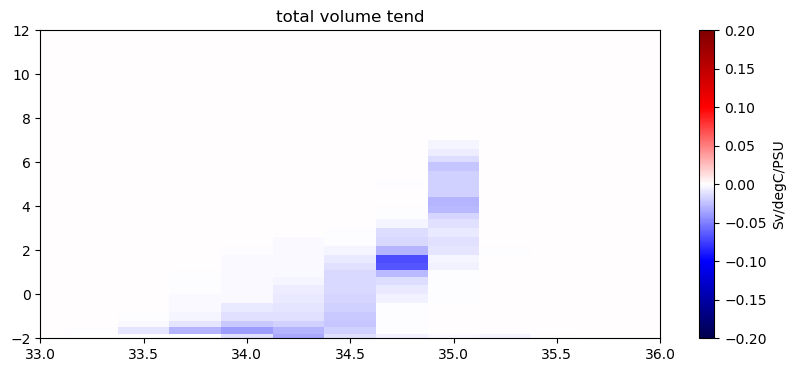

In [34]:
fig = plt.figure()

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin,Tbin,dVdt_TS * 1e-6 / binwidthS1tile / binwidthT1tile,cmap='seismic',vmin=-.2,vmax=0.2)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,36)
ax.set_ylim(-2,12)
plt.title("total volume tend")

In [35]:
print(np.nansum(tmptend*mymsk3d))
print(np.nansum(dVdt))  # this confirms that the volume change in the basin is the same as the volume change in the TS diagram

-87315.0459362239
-87315.04593622389


## load the values for Gterms

In [36]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [37]:

## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_TH.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFhT = DF_hconv

trWtopDF = -(DFrE_TH+DFrI_TH)

DFrT = np.zeros((nz,ny,nx),dtype=float)
DFrT[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

In [38]:
# to get the surface term, we need J/s and convert to degC.m^3/s
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# we need to create zconv_top and swtop
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,np.zeros((nz,ny,nx)))*mk3D_mod(RAC*oceQsw,np.zeros((nz,ny,nx)))   # J/s

# zconvtop_heat is here
zconv_top_heat = TFLUX * RAC     # W/m^2 * m^2 = J/s

In [39]:

def surface_contrib_JT(zconv_top_heat, swtop, rcp, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = swtop.shape

    eT = zconv_top_heat.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(swtop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eT[0] - swtop[1]) / rcp if np.ndim(binwidthT)==0 else \
           (eT[0] - swtop[1]) / rcp

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz-1] = -(swtop[2:nz] - swtop[1:nz-1]) / rcp

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftestT = surface_contrib_JT(zconv_top_heat,swtop,myparms['rcp'])    # this is in degC.m^3/s

In [40]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# do the vertical convergence for KPP
trWtopKPP = -(KPPg_TH)         # degC.m^3/s

tmpkppT = np.full((nz,ny,nx),np.nan)
tmpkppT[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

In [41]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

def plot_figure4_components(
    THETA,
    boundsT,
    binmidT,
    binwidthT1,
    testtend,
    *,
    iiT=None,
    mask=None,
    tendency_name="tmptend",
    **terms
):
    """
    Bin arbitrary component terms by temperature using binmidT intervals and plot:
      Top panel:   each term vs. T (edge-based, divided by binwidthT1)
      Bottom panel: sum(all components except 'tendency_name') vs the tendency term

    Parameters
    ----------
    THETA : array-like
        Tracer field used for binning. Shape must match each term.
    boundsT : 1D array-like
        Bin *edges* (length nT+1). x-locations will be boundsT[1:-1] (length nT-1).
    binmidT : 1D array-like
        Mid-bin edges used to define intervals: binmidT[i] <= THETA < binmidT[i+1]
        Length nT.
    binwidthT1 : 1D array-like
        Edge bin widths (length nT-1), used to convert summed fluxes to edge-based G.
    iiT : slice or 1D index array, optional
        Selection along the temperature-edge axis (length nT-1). Defaults to all.
    mask : array-like, optional
        Same shape as THETA (and each term). Elements where mask is falsy are ignored.
        If provided, terms are multiplied by mask and NaNs are set to zero for counting.
    tendency_name : str, default 'tmptend'
        The key in **terms that should be treated as the tendency curve on panel 2.
    **terms : dict of name -> array-like
        Component arrays to include (e.g., tmpkpp=..., ADVh=..., vdiff=..., surface=..., etc.)
        All arrays must have the same shape as THETA.

    Notes
    -----
    - The binning follows the “new” interpretation used previously:
        binmidT[i] <= THETA < binmidT[i+1], for i = 0..(nT-2)
      which yields nT-1 edge bins.
    - Each component is summed per bin, then divided by `binwidthT1` to give an
      edge-based G-like quantity per temperature edge.
    """

    # --- validate & prepare shapes ---
    THETA      = np.asarray(THETA)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)

    if mask is not None:
        mask = np.asarray(mask)
        if mask.shape != THETA.shape:
            raise ValueError("mask must have the same shape as THETA")

    nT   = boundsT.size - 1
    nTm1 = nT - 1
    if binmidT.size != nT:
        raise ValueError("binmidT must have length nT (= len(boundsT)-1)")
    if binwidthT1.size != nTm1:
        raise ValueError("binwidthT1 must have length nT-1 (= len(boundsT)-2 + 1)")

    # x-locations for edge-based curves (length nT-1)
    x = boundsT[1:-1]

    # default selection
    if iiT is None:
        iiT = slice(None)

    # --- flatten for binning ---
    theta_flat = THETA.ravel()

    # build the bin index via binmidT intervals
    # binmidT[i] <= THETA < binmidT[i+1], i = 0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)

    # if mask provided, fold it into validity
    if mask is not None:
        valid_mid &= (mask.ravel().astype(bool))

    idx_mid = bin_idx_mid[valid_mid]

    # --- per-term binning and edge conversion ---
    G_terms = {}  # name -> (nT-1,) array
    for name, arr in terms.items():
        arr = np.asarray(arr)
        if arr.shape != THETA.shape:
            raise ValueError(f"term '{name}' must have the same shape as THETA")

        vals = arr.ravel().astype(float)

        # Apply mask behavior similar to your snippets:
        #   multiply by mask, set NaNs to 0 for accumulation, but preserve 'all-NaN' as NaN via helper.
        if mask is not None:
            vals = vals * mask.ravel()

        # NaN-aware bin sums (helper will return NaN for bins with no finite contributions)
        S = _bincount_sum_with_nan(idx_mid, vals[valid_mid], nTm1)

        # Convert to edge-based G by dividing by binwidthT1
        G_terms[name] = S / binwidthT1

    # Separate tendency from components-to-sum
    tend_curve = G_terms.get(tendency_name, None)
    comp_names = [k for k in G_terms.keys() if k != tendency_name]

    # Sum across components (excluding tendency)
    if comp_names:
        G_sum = np.nansum(np.vstack([G_terms[k] for k in comp_names]), axis=0)
    else:
        G_sum = np.full(nTm1, np.nan)

    return G_terms


In [42]:
# we should also get the total tendency from the theta timeseries from ASTE 90
# we want the total tendency of volume(!) in m^3/s from the theta (J/s)

# load the tend from the get_Jterms and plot this

file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR","SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR
    thisSALTDR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt   # degC.m/
AB_gT = 0
tmptendT=(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # degC.m/s * m^2 = degC.m^3/s
tmptendT = tmptendT * mymsk3d                         # degC.m^3/s

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt   # PSU.m
tmptendS=(SALTDR)*mk3D_mod(RAC,SALTDR)                     # PSU.m/s * m^2 = PSU.m^3/s
tmptendS = tmptendS * mymsk3d                         # PSU.m^3/s

In [43]:
testTtend = dVdt_S

In [44]:
G_terms = plot_figure4_components(
    THETA,
    boundsT.flatten(),
    binmidT.flatten(),
    binwidthT1.flatten(),
    testTtend,
    mask=mymsk3d,                 # optional
    tendency_name="tmptend",      # change if your tendency is named differently
    tmpkpp=tmpkppT,
    ADVh=ADVhT,
    ADVr=ADVrT,
    DFh=DFhT,
    DFr=DFrT,
    surface=Ft_surftestT,
    tmptend=tmptendT,
)

In [45]:
# G_terms.keys()

In [46]:
name = "BarentsS"
Gsurf = G_T[name]['LaTs2TH']
GDFh  = G_T[name]['LaTh2TH']
GDFr  = G_T[name]['LaTz2TH']
GADVh = G_T[name]['LTha2TH']
GADVr = G_T[name]['LTza2TH']
Gtottend = G_T[name]['LTto2TH']

In [47]:

# # 3. Build a G(T) curve by cumulative sum in T (choosing a sign convention)
# dVdt_T = dVdt_T.reshape(1,111)
# nt, nT = dVdt_T.shape
# G_interfaces = np.zeros((nt, nT + 1))   # G at T-bin interfaces

# G_interfaces[:, 0] = 0.0                # boundary condition at coldest T

# # Here I use G_{k+1/2} = G_{k-1/2} + F_k
# for k in range(nT):
#     G_interfaces[:, k+1] = G_interfaces[:, k] + dVdt_T[:, k]

# # If you want G at T-bin centers:
# G_T_tmptest = 0.5 * (G_interfaces[:, :-1] + G_interfaces[:, 1:])  # (nt, nT)

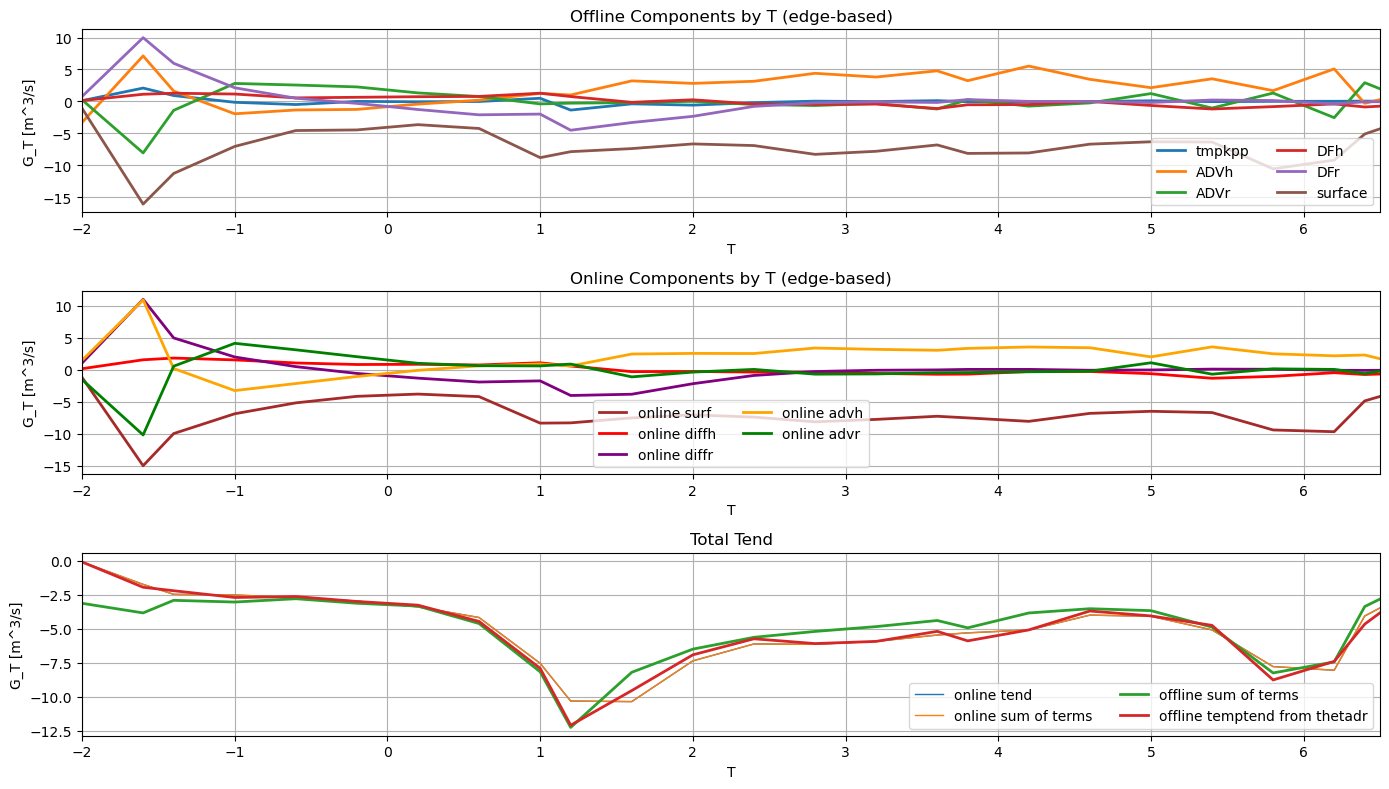

In [48]:
# --- plot ---
x = boundsT.flatten()[1:-1]
iiT = slice(None)
comp_names = [k for k in G_terms.keys() if k != "tmptend"]


plt.figure(figsize=(14, 8))

# Top: every component vs T
ax1 = plt.subplot(3, 1, 1)
total_calc = np.zeros_like(G_terms['ADVh'])
for name in comp_names:
    ax1.plot(x[iiT], G_terms[name][iiT]*1e-6, linewidth=2, label=name)
    total_calc += G_terms[name]*1e-6
if not comp_names:
    ax1.plot([], [], label="(no components provided)")

ax1.grid(True)
ax1.set_xlabel('T')
ax1.set_ylabel('G_T [m^3/s]')
ax1.set_title('Offline Components by T (edge-based)')
ax1.legend(ncol=2)
ax1.axis('tight')
ax1.set_xlim(-2,6.5)

ax1 = plt.subplot(3,1,2)

# plot the other lines as smaller
ax1.plot(x[iiT], Gsurf[iiT], linewidth=2, label="online surf",c="brown")
ax1.plot(x[iiT], GDFh[iiT], linewidth=2, label="online diffh",c="red")
ax1.plot(x[iiT], GDFr[iiT], linewidth=2, label="online diffr",c="purple")
ax1.plot(x[iiT], GADVh[iiT], linewidth=2, label="online advh",c="orange")
ax1.plot(x[iiT], GADVr[iiT], linewidth=2, label="online advr",c="green")
ax1.grid(True)
ax1.set_xlabel('T')
ax1.set_ylabel('G_T [m^3/s]')
ax1.set_title('Online Components by T (edge-based)')
ax1.legend(ncol=2)
ax1.axis('tight')
ax1.set_xlim(-2,6.5)


# bottom: compare to total dVdt
ax1 = plt.subplot(3, 1, 3)
ax1.plot(x[iiT], Gtottend[iiT],linewidth=1,label="online tend")
ax1.plot(x[iiT], Gsurf[iiT] + GDFh[iiT] + GDFr[iiT] + GADVh[iiT] + GADVr[iiT],linewidth=1,label="online sum of terms")
ax1.plot(x[iiT], total_calc[iiT],linewidth=2,label="offline sum of terms")
ax1.plot(x[iiT], G_terms["tmptend"][iiT]*1e-6,linewidth=2,label="offline temptend from thetadr")
# ax1.plot(x[iiT], dVdt_S[iiT],linewidth=2,label="offline temptend from thetadr* 3.5e-8")
ax1.grid(True)
ax1.set_xlabel('T')
ax1.set_ylabel('G_T [m^3/s]')
ax1.set_title('Total Tend')
ax1.legend(ncol=2)
ax1.axis('tight')
ax1.set_xlim(-2,6.5)

plt.tight_layout()

plt.savefig("compare_GT_online_offline.png",dpi=300)

## now do the same for the G_S terms

In [49]:
# maybe instead of verifying we can just skip to the tendency calculation for dVdt. that would be more smart
# rather than skipping through this whole thing

In [50]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhS = ADV_hconv

trWtopADV = -(ADVr_SLT)

ADVrS = np.zeros((nz,ny,nx),dtype=float)
ADVrS[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [51]:
# cool, do the same for diff


## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_SLT.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFhS = DF_hconv

trWtopDF = -(DFrE_SLT+DFrI_SLT)

DFrS = np.zeros((nz,ny,nx),dtype=float)
DFrS[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

In [52]:
# load the surface terms
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)

In [53]:
#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s

In [54]:
# do the vertical convergence for KPP
trWtopKPP = -(KPPg_SLT)         # PSU.m^3/s

tmpkppS = np.full((nz,ny,nx),np.nan)
tmpkppS[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

In [55]:
def surface_contrib_JT(zconv_top_salt, sptop, rho, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = sptop.shape

    eS = zconv_top_salt.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(sptop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eS[0] - sptop[1]) / rho if np.ndim(binwidthS)==0 else \
           (eS[0] - sptop[1]) / rho

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz] = -(sptop[1:nz] - sptop[0:nz-1]) / rho

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftestS = surface_contrib_JT(zconv_top_salt,sptop,myparms['rhoconst'])    # this is in PSU.m^3/s

## I'm wondering if the issue is that the dVdt budget is from the volume change and not the tend.

This would not be accumulation and would in fact be the change

In [56]:
# if we verified the correct calculation of the tendendcy from the tmptend for thetadr and saltdr can we get dVdt

In [57]:
# create the J terms correctly from tmpTendT and tmpTendS
# we want to create a tracer-based wmt diagram as we did with the G terms previously
nT,nS = 112,112
JtermsdVdt = np.zeros((2, nS-1, nT-1))
#          ^^^^^^^^^^^^^^^^^^^^^^^^^^^  <-- should usually be (2, nS, nT)

ysmsk, xsmsk = np.where(mymsk == 1)[0], np.where(mymsk == 1)[1]

aT = tmptendT    # (nz, ny, nx): degC*m^3/s
bS = tmptendS    # (nz, ny, nx): PSU*m^3/s

for i, j in zip(ysmsk, xsmsk):

    for k in range(nz):

        iTpt = int(binned_theta[k, i, j])
        iSpt = int(binned_salinity[k, i, j])

        # need to guard against NaNs / out-of-range
        if (iTpt < 0 or iTpt >= nT or
            iSpt < 0 or iSpt >= nS):
            continue

        # BUG: bT doesn’t exist; should be bS
        JaT = aT[k, i, j] / binwidthT1[iTpt] * ffac  # Sv
        JbS = bS[k, i, j] / binwidthS1[iSpt] * ffac  # Sv

        # accumulate
        JtermsdVdt[0, iSpt, iTpt] += JaT
        JtermsdVdt[1, iSpt, iTpt] += JbS


In [58]:
J_T = JtermsdVdt[0, :, :]   # shape (nS, nT)
J_S = JtermsdVdt[1, :, :]

In [59]:
J_S.shape

(111, 111)

In [60]:
divJ = np.zeros_like(J_T)

# central differences in interior
for s in range(1, nS-2):
    for t in range(1, nT-2):
        dJdT = (J_S[s, t+1] - J_S[s, t-1]) / (binwidthS1[t+1] + binwidthS1[t-1]) * 2.0
        dJdS = (J_T[s+1, t] - J_T[s-1, t]) / (binwidthT1[s+1] + binwidthT1[s-1]) * 2.0
        divJ[s, t] = dJdT + dJdS


(-2.0, 10.0)

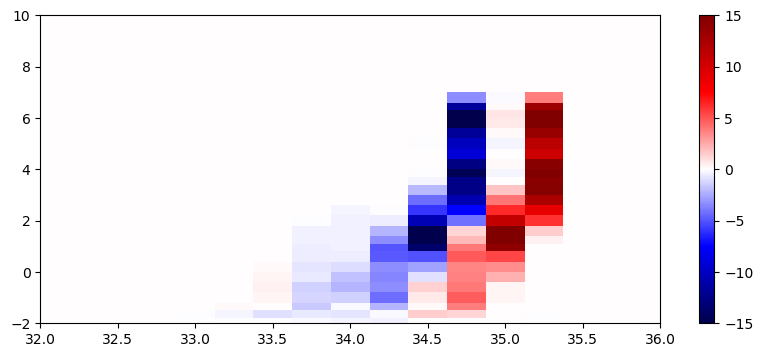

In [61]:
plt.pcolormesh(Sbin,Tbin,divJ,cmap='seismic',vmin=-15,vmax=15)
plt.colorbar()
plt.xlim(32,36)
plt.ylim(-2,10)

## calculate the J terms (these have been validated)

In [62]:
# THESE ARE VERIFIED AS MATCHING THE LAYERS PACKAGE

JtermsT = np.zeros((6,nS-1,nT-1))

# get the data (will be the same for all points)
aT = ADVhT
bT = ADVrT
cT = DFhT
dT = DFrT
eT = Ft_surftestT
fT = tmpkppT

for i,j in zip(ysmsk,xsmsk):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JADVTh = (aT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac             # Sv/PSU/degC
        JADVTr = (bT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JDFTh = (cT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JDFTr = (dT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JsurfT = (eT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JkppT = (fT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JADVTh,JADVTr,JDFTh,JDFTr,JsurfT,JkppT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

JtermsS = np.zeros((6,nS-1,nT-1))


# get the data (will be the same for all points)
aS = ADVhS  # this is in PSU.m^3/s
bS = ADVrS
cS = DFhS
dS = DFrS
eS = Ft_surftestS
fS = tmpkppS

for i,j in zip(ysmsk,xsmsk):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JADVSh = (aS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac             # Sv/PSU/degC
        JADVSr = (bS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JDFSh = (cS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JDFSr = (dS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JsurfS = (eS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JkppS = (fS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JADVSh,JADVSr,JDFSh,JDFSr,JsurfS,JkppS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

In [63]:
def calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile, bc="zero"):
    """
    Compute convergence in TS space with same-shape output.
    JtermsS, JtermsT: arrays shaped (nterms, nS, nT)
    binwidthS1tile, binwidthT1tile: broadcastable to (nS, nT)
    bc: "zero" (default) or "periodic"
    """
    conv = np.zeros_like(JtermsS)
    convUa = np.zeros_like(JtermsS)
    convVa = np.zeros_like(JtermsS)
    nterms = JtermsS.shape[0]

    for i in range(nterms):
        JS = JtermsS[i]  # flux along S-axis   m^3/s/degC
        JT = JtermsT[i]  # flux along T-axis   m^3/s/PSU

        # same-shape arrays
        convU = np.zeros_like(JS)
        convV = np.zeros_like(JT)

        # interior differences (lose one neighbor, keep shape by assigning into interior)
        convU[:, :-1] = JS[:, :-1] - JS[:, 1:]      # d/dS of S-flux
        convV[:-1, :] = JT[:-1, :] - JT[1:, :]      # d/dT of T-flux

        convU[:, -1] = 0.0
        convV[-1, :] = 0.0

        # normalize by bin widths (broadcasts)
        convU = convU / binwidthS1tile       # m/s/degC/PSU
        convV = convV / binwidthT1tile       # m/s/PSU/degC

        # total convergence for this term
        conv[i] = convU + convV
        convUa[i] = convU
        convVa[i] = convV

    return conv,convUa,convVa

TSconv,convU,convV = calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile)

In [64]:
J_S.shape

(111, 111)

In [65]:
TSconvall,convU,convV = calc_UV_conv_TS(J_S.reshape(1,111,111), J_T.reshape(1,111,111), binwidthS1tile, binwidthT1tile)

(-2.0, 10.0)

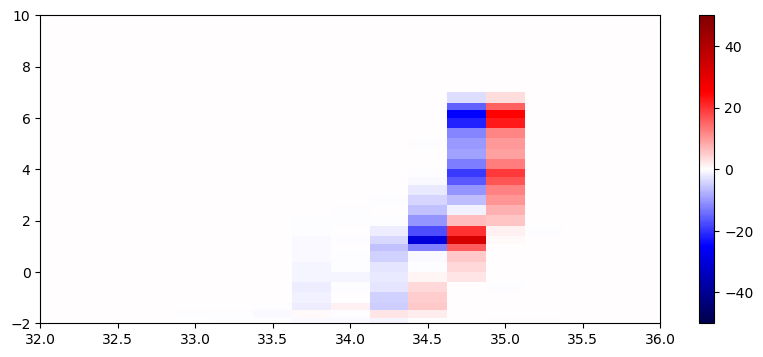

In [66]:
plt.pcolormesh(Sbin,Tbin,np.nansum(-TSconvall,axis=0),cmap='seismic',vmin=-50,vmax=50)
plt.colorbar()
plt.xlim(32,36)
plt.ylim(-2,10)

(-2.0, 10.0)

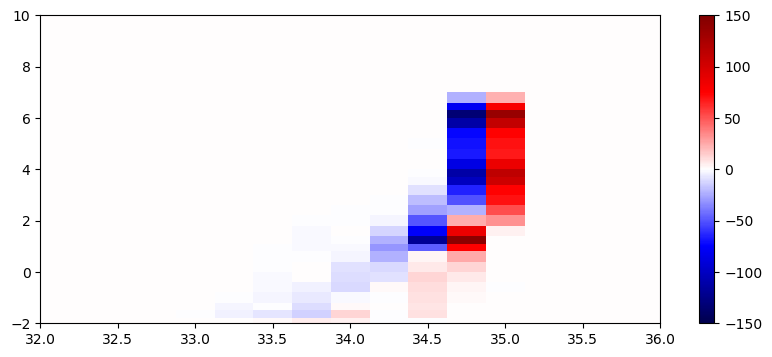

In [67]:
plt.pcolormesh(Sbin,Tbin,np.nansum(-TSconv[2:],axis=0),cmap='seismic',vmin=-150,vmax=150)
plt.colorbar()
plt.xlim(32,36)
plt.ylim(-2,10)

## Load the gateways from here and see (I think I did this elsewhere?)

In [68]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1


# change the gate labels for SFJ because this was very wrong
result = choose_UV_sfj.copy()

# print(choose_UV_sfj)

# for i in [3,11,20,28,37]:
for i in [3,20,28,37]:     # these are the indices where we need both the x and y terms for the budget
    result[i] = "B"

# we also need to change manually some of the V terms
for i in [2,10,19,27,36]:
    result[i] = "H"

print()
# print(result)
choose_UV_sfj = result


# the BSO reading is also wrong
choose_UV_bso[20] = "H"
x_bso[x_bso == 161] = 162

In [69]:
# we should redefine gates I think
# start with NaNs (float array so NaN is valid)
gates = np.full((ny, nx), np.nan, dtype=float)

def _paint(x_idx, y_idx, value):
    x = np.asarray(x_idx, dtype=int)
    y = np.asarray(y_idx, dtype=int)
    # keep only points inside the domain
    m = (y >= 0) & (y < ny) & (x >= 0) & (x < nx)
    gates[y[m], x[m]] = value

# 1,2,3,4 for BSO, SFJ, FJNZ, NZRU
_paint(x_bso,  y_bso,  1)
_paint(x_sfj,  y_sfj,  2)
_paint(x_fjnz, y_fjnz, 3)
_paint(x_nzru, y_nzru, 4)

In [70]:
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

In [71]:
# INDICES WE WANT TO READ FROM 
# make long sets of these so we can loop through later
ix_all = np.concatenate((x_bso,x_sfj,x_fjnz,x_nzru))
iy_all = np.concatenate((y_bso,y_sfj,y_fjnz,y_nzru))
choose_all = np.concatenate((choose_UV_bso,choose_UV_sfj,choose_UV_fjnz,choose_UV_nzru))

In [74]:
# just do this with UVEL and VVEL to see
# copy the UVEL and VVEL calculation and grabbing of the gates here

# create the volume and bin this
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)

In [75]:
# try to grab just the gateway terms (these are advection * rhoconst)

# I think it would make the most sense to do this as a dictionary for each of the gates
# each key in the dictionary will be the advective contribution of that gate
ADV_gates = {}

# WRITE THIS AGAIN SO I REMEMBER, WHEN H WE WANT TO CHOOSE THE X TERM WHEN V WE WANT TO CHOOSE THE Y TERM

# do for the BSO based on the y,x,and choose_UV
ADV_BSO = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_bso,x_bso,choose_UV_bso):
    # if the direction is V (face3), we select the ADV from the indices of y_bso and x_bso but we want to put this at y_bso-1
    # this would be the face we tag for the T and S bins
    if direction == "H":
        ADV_BSO[:,j,i] += UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
    elif direction == "V":
        ADV_BSO[:,j-1,i] -= VVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]  # assuming we selected from the correct index of bso which I think we did
ADV_gates["BSO"] = ADV_BSO

# do for fjnz baed on the same thing, this will all be at H so we just need the x term, same for the last one
# these are all H -- use the ADVx term at i-1
ADV_FJNZ = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_fjnz,x_fjnz,choose_UV_fjnz):
    ADV_FJNZ[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
ADV_gates["FJNZ"] = ADV_FJNZ

ADV_NZRU = np.zeros((nz,ny,nx))
for j,i,direction in zip(y_nzru,x_nzru,choose_UV_nzru):
    ADV_NZRU[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
ADV_gates["NZRU"] = ADV_NZRU

## SFJ looks wrong -- try again

# do for SFJ based on y,x, and choose_UV
ADV_SFJ = np.zeros((nz,ny,nx))  # we're setting this at the location we want to read from already in the z,y,x grid
for j,i,direction in zip(y_sfj,x_sfj,choose_UV_sfj):
    if direction == "H":
        ADV_SFJ[:,j,i-1] -= UVELMASS[:,j,i]  * DYG3d[:,j,i] * DRF3d[:,j,i]  # set at i-1 because we're taking at the right of the gate
    elif direction == "V":
        ADV_SFJ[:,j-1,i] -= VVELMASS[:,j,i]  * DYG3d[:,j,i] * DRF3d[:,j,i]   # set at j-1 because we're taking from the top of the gate
    elif direction == "B":
        # we need to add these to the cells below and the cells above
        ADV_SFJ[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
        ADV_SFJ[:,j-1,i] -= VVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
ADV_gates["SFJ"] = ADV_SFJ

In [79]:
# get the TS distribution for this
# this is where we try to put the salt terms into a TS mesh
# we need to go through the ADV points in each gate and add them to the TS bin at that point

norm = (1)
J_gates = np.zeros((4,nS-1,nT-1))

#########################################################################################################################
f3start = np.where(choose_UV_bso == "V")[0][0]   # we need to define this index for the start of face 3 for the BSO

for j,i,direction in zip(y_bso[:f3start],x_bso[:f3start],choose_UV_bso[:f3start]):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["BSO"][:,j,i]

    nzc = len(binned_theta[:,j,i][~np.isnan(binned_theta[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / norm

for j,i,direction in zip(y_bso[f3start:],x_bso[f3start:],choose_UV_bso[f3start:]):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["BSO"][:,j-1,i]

    nzc = len(binned_theta[:,j-1,i][~np.isnan(binned_theta[:,j-1,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i])
        iSpt = int(binned_salinity[kc,j-1,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / norm   # 

#########################################################################################################################
# do this for SFJ
for j,i,direction in zip(y_sfj,x_sfj,choose_UV_sfj):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["SFJ"][:,j-1,i-1]
    nzc = len(binned_theta[:,j-1,i-1][~np.isnan(binned_theta[:,j-1,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j-1,i-1])
        iSpt = int(binned_salinity[kc,j-1,i-1])
        J_gates[1,iSpt,iTpt] += (col[kc]) / norm

#########################################################################################################################
# same for FJNZ
for j,i,direction in zip(y_fjnz,x_fjnz,choose_UV_fjnz):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["FJNZ"][:,j,i-1]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[2,iSpt,iTpt] += (col[kc]) / norm

#########################################################################################################################
# same again for NZRU
for j,i,direction in zip(y_nzru,x_nzru,choose_UV_nzru):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADV_gates["NZRU"][:,j,i-1]
    nzc = len(binned_theta[:,j,i-1][~np.isnan(binned_theta[:,j,i-1])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[3,iSpt,iTpt] += (col[kc]) / norm


#############################################################################################################################
J_gates *= 1e-6

In [80]:
J_gates.shape

(4, 111, 111)

In [81]:
for i in range(4):
    J_gates[i] /= binwidthT1tile
    J_gates[i] /= binwidthS1tile

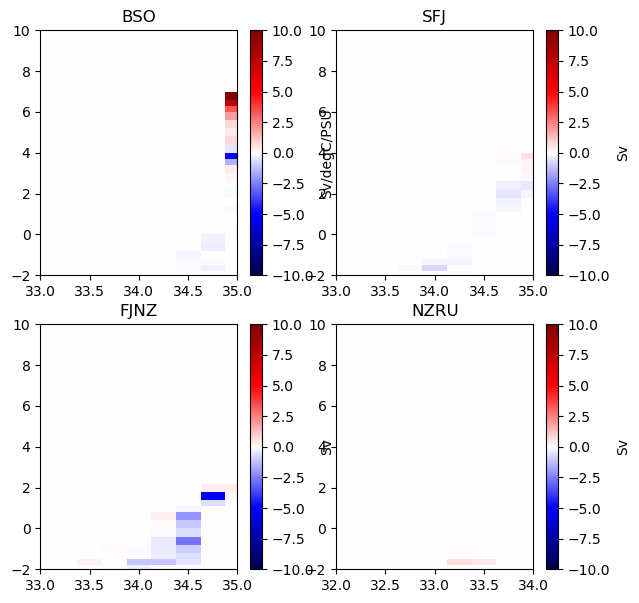

In [84]:
# plot my favorite 2x2 here for the four gates and see if this looks reasonable based on the output

vlev = 10

fig = plt.figure(figsize=(7,7))

ax = plt.subplot(221)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[0],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("BSO")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv/degC/PSU")

ax = plt.subplot(222)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[1],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("SFJ")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv")

ax = plt.subplot(223)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[2],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("FJNZ")
ax.set_xlim(33,35)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv")

ax = plt.subplot(224)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[3],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("NZRU")
ax.set_xlim(32,34)
ax.set_ylim(-2,10)
plt.colorbar(cb,label="Sv")

In [85]:
J_all = np.nansum(J_gates,axis=0)

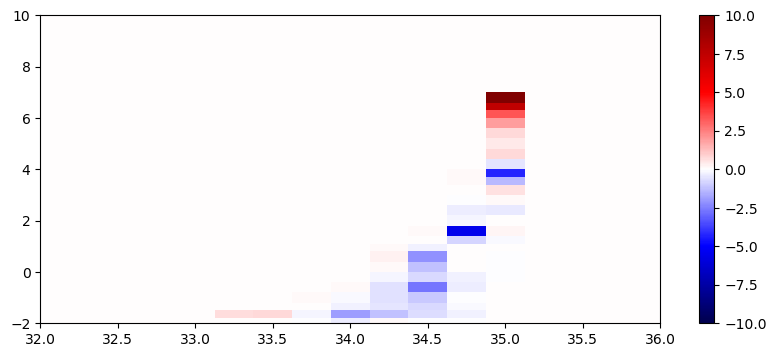

In [88]:
plt.pcolormesh(Sbin,Tbin,J_all,cmap='seismic',vmin=-vlev,vmax=vlev)
plt.xlim(32,36)
plt.ylim(-2,10)
plt.colorbar()

(-2.0, 10.0)

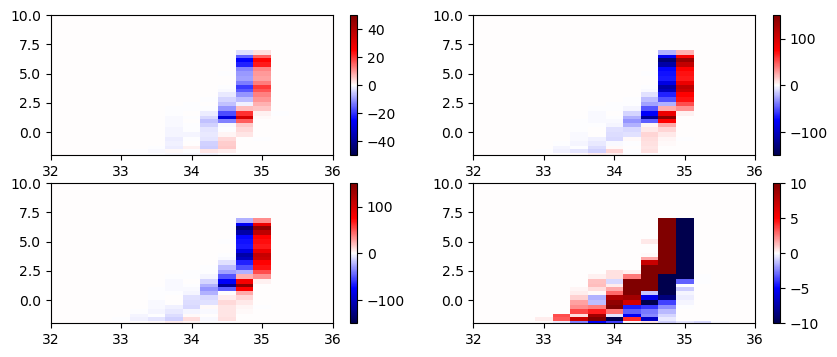

In [90]:
fig = plt.figure()

ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(-TSconvall,axis=0),cmap='seismic',vmin=-50,vmax=50)
plt.colorbar(cb)
ax.set_xlim(32,36)
ax.set_ylim(-2,10)

ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(-TSconv[2:],axis=0),cmap='seismic',vmin=-150,vmax=150)
plt.colorbar(cb)
ax.set_xlim(32,36)
ax.set_ylim(-2,10)

ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin,Tbin,J_all + np.nansum(-TSconv[2:],axis=0),cmap='seismic',vmin=-150,vmax=150)
plt.colorbar(cb)
ax.set_xlim(32,36)
ax.set_ylim(-2,10)

ax = plt.subplot(224)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(-TSconvall,axis=0) - (J_all + np.nansum(-TSconv[2:],axis=0)),cmap='seismic',vmin=-vlev,vmax=vlev)
plt.colorbar(cb)
ax.set_xlim(32,36)
ax.set_ylim(-2,10)